In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from math import sin
from math import pi
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from math import sqrt
from keras.optimizers import RMSprop

In [2]:
warnings.simplefilter('ignore')

Считываем данные и посмотрим на них

In [3]:
data = pd.read_csv('products.csv', sep='|', error_bad_lines=False)

In [4]:
data.head()

,WEEK,PLN,PLN_LABEL,PRODUCT_CATEGORY,PRODUCT_CATEGORY_LABEL,OPSTUDY,OPSTUDY_LABEL,ACTUAL,BU,SEG,PROMO
0,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,2,Consumables,B,N
1,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,36,Consumables,C4,N
2,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1198,Health/Wellness,A,Y
3,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,9,Health/Wellness,A,N
4,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1479,Health/Wellness,C1,Y


In [5]:
def replace_negative(x):
    if x<0:
        return 0
    else:
        return x

In [6]:
def date_divide(x):
    x=x[1:]
    x='20' + x
    x=x[:4] + '-' + x[4:]
    x=x[:7] + '-' + x[7:]
    return x

In [7]:
aggregation = {
    'ACTUAL': 'sum',
    'PROMO': 'max',
    'YEAR': 'max',
    'MONTH': 'max',
    'DAY': 'max'
}

In [8]:
def sin_day(val):
    return sin(val*(2*pi)/31)

In [9]:
def sin_month(val):
    return sin(val*(2*pi)/12)

Выберем определенный opstudy (например 51) и будем с ним работать

In [10]:
opst_51 = data[data['OPSTUDY']==51].copy()

Удалим в новом датасете столбцы 'OPSTUDY', 'OPSTUDY_LABEL', 'BU', так как мы уже определились с opstudy; колонку 'SEG' удалим, так как она не очень информативна; также удалим все остальные описательные характеристики продуктов 

In [11]:
opst_51.drop(['PLN_LABEL', 'PRODUCT_CATEGORY', 'PRODUCT_CATEGORY_LABEL', 'OPSTUDY', 'OPSTUDY_LABEL', 'BU', 'SEG'], axis=1, inplace=True)

Преобразуем наши данные в необходимые типы, а также приведем колонку 'WEEK' в нужный строковый тип при помощи функции date_divide, чтобы потом привести в дату

In [12]:
opst_51['WEEK'] = opst_51['WEEK'].apply(lambda x: str(x))
opst_51['PLN'] = opst_51['PLN'].apply(lambda x: str(x))
opst_51['ACTUAL'] = opst_51['ACTUAL'].apply(lambda x: float(x))
opst_51['PROMO'] = opst_51['PROMO'].apply(lambda x: str(x))
opst_51['WEEK'] = opst_51['WEEK'].apply(lambda x: date_divide(x))

Приводим 'WEEK' в дату и создаем еще три колонки: год, месяц и день (неделю)

In [13]:
opst_51['WEEK'] = pd.to_datetime(opst_51['WEEK'])
opst_51['YEAR'] = [d.year for d in opst_51['WEEK']]
opst_51['MONTH'] = [d.month for d in opst_51['WEEK']]
opst_51['DAY'] = [d.day for d in opst_51['WEEK']]

Создаем словарь и заменяем колонку 'PROMO' на числовые значения; кроме того в колонке часто встречаются пропуски, это связано с тем, что в наших данных встречаются для одних и тех же pln повторяющиеся недели. В таких случаях одно из значений будет 0 или 1 а другие nan. Заменим пока все nan на 0, а затем при агрегации будем брать максимум (если хотя бы в одной недели была 1, то значит 'PROMO' принимает значение 1)

In [14]:
promo_dict = {'N':0, 'Y':1}
opst_51['PROMO'] = opst_51['PROMO'].replace(promo_dict)
opst_51['PROMO'] = opst_51['PROMO'].replace({'nan':0})

Проведем агрегацию данных по дате и pln

In [15]:
opst_51 = opst_51.groupby(['WEEK', 'PLN'], as_index=False).agg(aggregation)

Возьмем первый попавшийся pln и сделаем отдельно для него прогноз

In [16]:
first_pln = opst_51[opst_51['PLN']=='40000131497'].copy()

In [17]:
first_pln.drop('PLN', axis=1, inplace=True)

Введем новый признак - среднее значение продаж по каждому месяцу

In [18]:
first_pln['YEAR_MONTH'] = [str(d.year) + '/' + str(d.month) for d in first_pln['WEEK']]
year_month = np.unique(first_pln['YEAR_MONTH'].values)
ym_mean = np.array([first_pln[first_pln['YEAR_MONTH']==d]['ACTUAL'].mean() for d in year_month])
mean_dict = dict(zip(year_month, ym_mean))
first_pln['MEAN_PER_MONTH'] = first_pln['YEAR_MONTH'].replace(mean_dict)

Значения данных в зависимости от признака сильно разнятся, поэтому нормализируем наши данные о продажах и среднее по месяцам

In [19]:
scaler = MinMaxScaler()
scaler.fit(np.array(first_pln['ACTUAL']).reshape(-1, 1))
norm_act = scaler.transform(np.array(first_pln['ACTUAL']).reshape(-1, 1))
first_pln['ACTUAL'] = norm_act.ravel()

In [20]:
scaler.fit(np.array(first_pln['MEAN_PER_MONTH']).reshape(-1, 1))
norm_act = scaler.transform(np.array(first_pln['MEAN_PER_MONTH']).reshape(-1, 1))
first_pln['MEAN_PER_MONTH'] = norm_act.ravel()

Приведем также признаки месяц и день к синусу и косинусу, располагая дни\месяца на тригонометрической окружности; признак 'YEAR' удалим

In [21]:
first_pln.reset_index(inplace=True)
first_pln.set_index('WEEK', inplace=True)
first_pln.drop(['YEAR_MONTH', 'YEAR'], axis=1, inplace=True)
first_pln['MONTH'] = first_pln['MONTH'].apply(lambda m: sin_month(m))
first_pln['DAY'] = first_pln['DAY'].apply(lambda d: sin_day(d))
first_pln.reset_index('WEEK', inplace=True)
first_pln.drop('index', axis=1, inplace=True)

Взглянем на получившиеся данные

In [22]:
first_pln.head()

,WEEK,ACTUAL,PROMO,MONTH,DAY,MEAN_PER_MONTH
0,2015-02-08,0.046961,0,0.866025,0.998717,0.037634
1,2015-02-15,0.039595,0,0.866025,0.101168,0.037634
2,2015-02-22,0.039595,0,0.866025,-0.968077,0.037634
3,2015-03-01,0.033149,0,1.000000,0.201299,0.083073
4,2015-03-08,0.067219,0,1.000000,0.998717,0.083073


Построим графики продаж и среднего за месяц

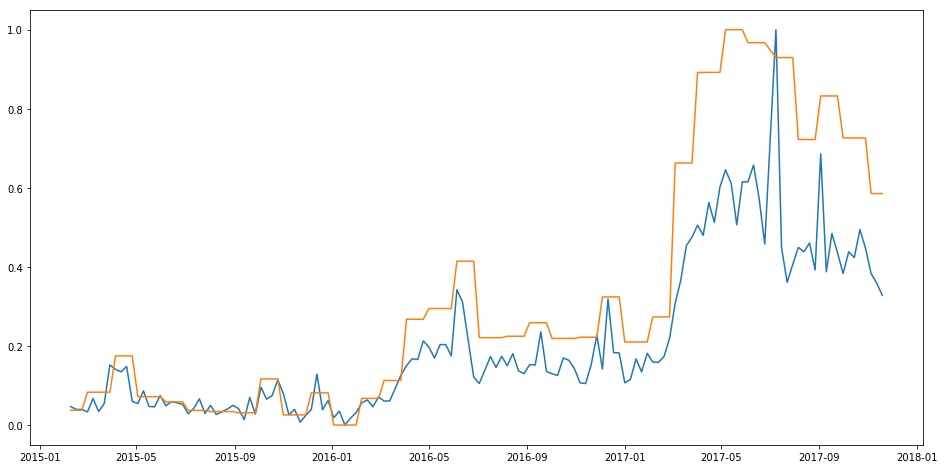

In [23]:
plt.figure(figsize=(16,8))
plt.plot(first_pln['WEEK'], first_pln['ACTUAL'])
plt.plot(first_pln['WEEK'], first_pln['MEAN_PER_MONTH'])
plt.show()

Графики дней и месяцев

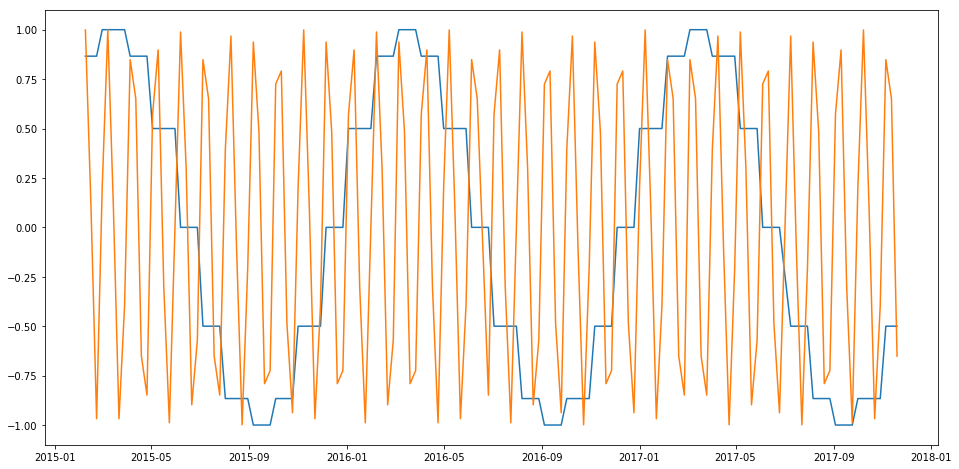

In [24]:
plt.figure(figsize=(16,8))
plt.plot(first_pln['WEEK'], first_pln['MONTH'])
plt.plot(first_pln['WEEK'], first_pln['DAY'])
plt.show()

Поставим целевой признак в конец датасета

In [25]:
act = first_pln['ACTUAL']
first_pln.drop('ACTUAL', axis=1, inplace = True)
first_pln.insert(5, 'ACTUAL', act)

In [26]:
first_pln['WEEK'] = first_pln['WEEK'].apply(lambda x: str(x))

In [27]:
first_pln.set_index('WEEK', inplace=True)

In [73]:
first_pln.head()

,PROMO,MONTH,DAY,MEAN_PER_MONTH,ACTUAL
WEEK,,,,,
2015-02-08 00:00:00,0,0.866025,0.998717,0.037634,0.046961
2015-02-15 00:00:00,0,0.866025,0.101168,0.037634,0.039595
2015-02-22 00:00:00,0,0.866025,-0.968077,0.037634,0.039595
2015-03-01 00:00:00,0,1.000000,0.201299,0.083073,0.033149
2015-03-08 00:00:00,0,1.000000,0.998717,0.083073,0.067219


Преобразуем еще немного наши данные, а именно измених их размерности (для того, чтобы скормить их нашей сети необходимо привести их к трехмерным тензорам); помимо этого разделим наш набор на тестовую и обучающую выборки

In [74]:
lstm_data = first_pln.values

In [75]:
train = lstm_data[:100, :]
test = lstm_data[100:, :]
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(100, 1, 4) (100,) (44, 1, 4) (44,)


Входным слоем нашей сети будет lstm слой, оптимизатор - RMSprop, для оценки ошибки возьмем среднюю абсолютную ошибку, в качестве валидационных данных возьмем тестовую выборку

In [76]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=RMSprop())
history = model.fit(X_train, y_train, epochs=700, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 100 samples, validate on 44 samples
Epoch 1/700
 - 1s - loss: 0.1101 - val_loss: 0.3937
Epoch 2/700
 - 0s - loss: 0.0898 - val_loss: 0.3731
Epoch 3/700
 - 0s - loss: 0.0785 - val_loss: 0.3570
Epoch 4/700
 - 0s - loss: 0.0700 - val_loss: 0.3430
Epoch 5/700
 - 0s - loss: 0.0637 - val_loss: 0.3307
Epoch 6/700
 - 0s - loss: 0.0595 - val_loss: 0.3197
Epoch 7/700
 - 0s - loss: 0.0567 - val_loss: 0.3096
Epoch 8/700
 - 0s - loss: 0.0544 - val_loss: 0.3005
Epoch 9/700
 - 0s - loss: 0.0529 - val_loss: 0.2929
Epoch 10/700
 - 0s - loss: 0.0518 - val_loss: 0.2860
Epoch 11/700
 - 0s - loss: 0.0509 - val_loss: 0.2800
Epoch 12/700
 - 0s - loss: 0.0501 - val_loss: 0.2767
Epoch 13/700
 - 0s - loss: 0.0496 - val_loss: 0.2737
Epoch 14/700
 - 0s - loss: 0.0492 - val_loss: 0.2705
Epoch 15/700
 - 0s - loss: 0.0490 - val_loss: 0.2678
Epoch 16/700
 - 0s - loss: 0.0487 - val_loss: 0.2645
Epoch 17/700
 - 0s - loss: 0.0486 - val_loss: 0.2625
Epoch 18/700
 - 0s - loss: 0.0482 - val_loss: 0.2591
Epoch 19/7

Epoch 154/700
 - 0s - loss: 0.0213 - val_loss: 0.0601
Epoch 155/700
 - 0s - loss: 0.0212 - val_loss: 0.0620
Epoch 156/700
 - 0s - loss: 0.0212 - val_loss: 0.0602
Epoch 157/700
 - 0s - loss: 0.0211 - val_loss: 0.0616
Epoch 158/700
 - 0s - loss: 0.0212 - val_loss: 0.0603
Epoch 159/700
 - 0s - loss: 0.0208 - val_loss: 0.0619
Epoch 160/700
 - 0s - loss: 0.0210 - val_loss: 0.0603
Epoch 161/700
 - 0s - loss: 0.0212 - val_loss: 0.0621
Epoch 162/700
 - 0s - loss: 0.0213 - val_loss: 0.0604
Epoch 163/700
 - 0s - loss: 0.0211 - val_loss: 0.0615
Epoch 164/700
 - 0s - loss: 0.0209 - val_loss: 0.0606
Epoch 165/700
 - 0s - loss: 0.0208 - val_loss: 0.0614
Epoch 166/700
 - 0s - loss: 0.0207 - val_loss: 0.0610
Epoch 167/700
 - 0s - loss: 0.0208 - val_loss: 0.0605
Epoch 168/700
 - 0s - loss: 0.0214 - val_loss: 0.0623
Epoch 169/700
 - 0s - loss: 0.0212 - val_loss: 0.0605
Epoch 170/700
 - 0s - loss: 0.0211 - val_loss: 0.0618
Epoch 171/700
 - 0s - loss: 0.0210 - val_loss: 0.0606
Epoch 172/700
 - 0s - loss: 

Epoch 306/700
 - 0s - loss: 0.0209 - val_loss: 0.0641
Epoch 307/700
 - 0s - loss: 0.0205 - val_loss: 0.0639
Epoch 308/700
 - 0s - loss: 0.0204 - val_loss: 0.0644
Epoch 309/700
 - 0s - loss: 0.0210 - val_loss: 0.0650
Epoch 310/700
 - 0s - loss: 0.0207 - val_loss: 0.0639
Epoch 311/700
 - 0s - loss: 0.0203 - val_loss: 0.0642
Epoch 312/700
 - 0s - loss: 0.0207 - val_loss: 0.0649
Epoch 313/700
 - 0s - loss: 0.0209 - val_loss: 0.0638
Epoch 314/700
 - 0s - loss: 0.0203 - val_loss: 0.0642
Epoch 315/700
 - 0s - loss: 0.0204 - val_loss: 0.0641
Epoch 316/700
 - 0s - loss: 0.0206 - val_loss: 0.0652
Epoch 317/700
 - 0s - loss: 0.0210 - val_loss: 0.0641
Epoch 318/700
 - 0s - loss: 0.0205 - val_loss: 0.0646
Epoch 319/700
 - 0s - loss: 0.0207 - val_loss: 0.0640
Epoch 320/700
 - 0s - loss: 0.0203 - val_loss: 0.0647
Epoch 321/700
 - 0s - loss: 0.0211 - val_loss: 0.0651
Epoch 322/700
 - 0s - loss: 0.0207 - val_loss: 0.0640
Epoch 323/700
 - 0s - loss: 0.0201 - val_loss: 0.0646
Epoch 324/700
 - 0s - loss: 

Epoch 458/700
 - 0s - loss: 0.0206 - val_loss: 0.0670
Epoch 459/700
 - 0s - loss: 0.0209 - val_loss: 0.0677
Epoch 460/700
 - 0s - loss: 0.0205 - val_loss: 0.0673
Epoch 461/700
 - 0s - loss: 0.0203 - val_loss: 0.0674
Epoch 462/700
 - 0s - loss: 0.0203 - val_loss: 0.0674
Epoch 463/700
 - 0s - loss: 0.0206 - val_loss: 0.0672
Epoch 464/700
 - 0s - loss: 0.0209 - val_loss: 0.0678
Epoch 465/700
 - 0s - loss: 0.0206 - val_loss: 0.0671
Epoch 466/700
 - 0s - loss: 0.0202 - val_loss: 0.0674
Epoch 467/700
 - 0s - loss: 0.0204 - val_loss: 0.0671
Epoch 468/700
 - 0s - loss: 0.0205 - val_loss: 0.0674
Epoch 469/700
 - 0s - loss: 0.0207 - val_loss: 0.0683
Epoch 470/700
 - 0s - loss: 0.0208 - val_loss: 0.0670
Epoch 471/700
 - 0s - loss: 0.0203 - val_loss: 0.0681
Epoch 472/700
 - 0s - loss: 0.0212 - val_loss: 0.0684
Epoch 473/700
 - 0s - loss: 0.0208 - val_loss: 0.0677
Epoch 474/700
 - 0s - loss: 0.0205 - val_loss: 0.0676
Epoch 475/700
 - 0s - loss: 0.0203 - val_loss: 0.0679
Epoch 476/700
 - 0s - loss: 

Epoch 610/700
 - 0s - loss: 0.0202 - val_loss: 0.0699
Epoch 611/700
 - 0s - loss: 0.0206 - val_loss: 0.0695
Epoch 612/700
 - 0s - loss: 0.0204 - val_loss: 0.0705
Epoch 613/700
 - 0s - loss: 0.0204 - val_loss: 0.0697
Epoch 614/700
 - 0s - loss: 0.0208 - val_loss: 0.0698
Epoch 615/700
 - 0s - loss: 0.0201 - val_loss: 0.0725
Epoch 616/700
 - 0s - loss: 0.0208 - val_loss: 0.0707
Epoch 617/700
 - 0s - loss: 0.0204 - val_loss: 0.0705
Epoch 618/700
 - 0s - loss: 0.0201 - val_loss: 0.0704
Epoch 619/700
 - 0s - loss: 0.0203 - val_loss: 0.0698
Epoch 620/700
 - 0s - loss: 0.0203 - val_loss: 0.0702
Epoch 621/700
 - 0s - loss: 0.0202 - val_loss: 0.0710
Epoch 622/700
 - 0s - loss: 0.0203 - val_loss: 0.0701
Epoch 623/700
 - 0s - loss: 0.0207 - val_loss: 0.0702
Epoch 624/700
 - 0s - loss: 0.0200 - val_loss: 0.0705
Epoch 625/700
 - 0s - loss: 0.0205 - val_loss: 0.0699
Epoch 626/700
 - 0s - loss: 0.0202 - val_loss: 0.0700
Epoch 627/700
 - 0s - loss: 0.0200 - val_loss: 0.0703
Epoch 628/700
 - 0s - loss: 

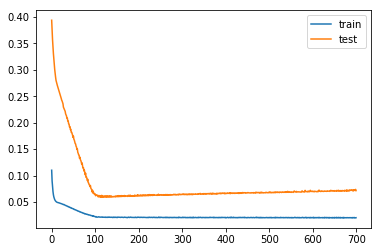

In [77]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Найдем прогноз и посчитаем среднеквадратичную ошибку

In [78]:
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 68.316


Графики предсказания и тестовой выборки

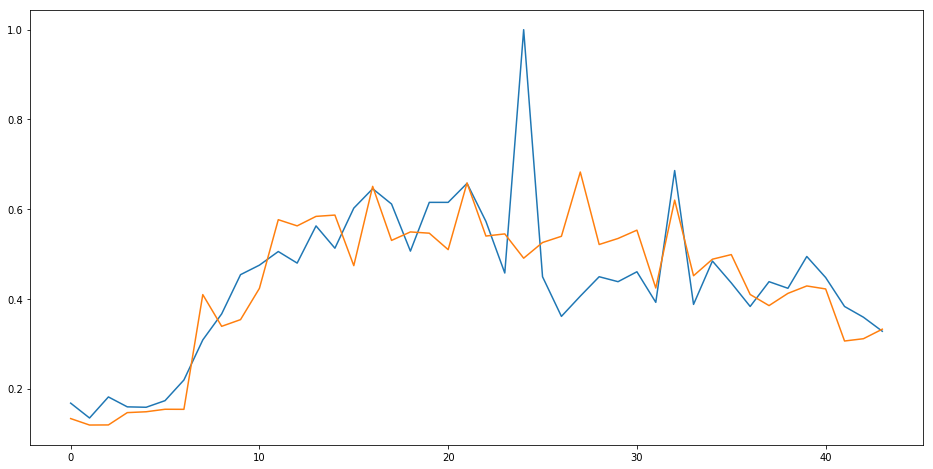

In [79]:
plt.figure(figsize=(16,8))
plt.plot(y_test)
plt.plot(yhat)
plt.show()

Возьмем какой-нибудь новый pln и построим для него другую сеть

In [80]:
second_pln = opst_51[opst_51['PLN']=='40000131505'].copy()

In [81]:
second_pln.drop('PLN', axis=1, inplace=True)

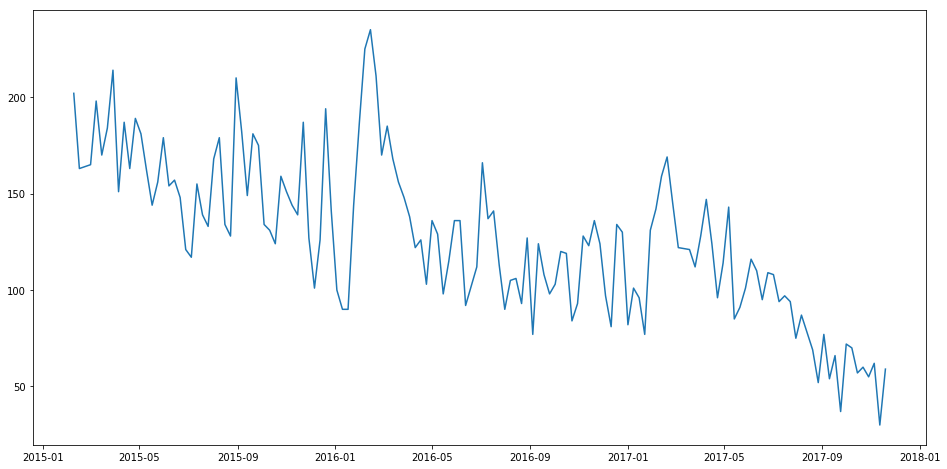

In [82]:
plt.figure(figsize=(16,8))
plt.plot(second_pln['WEEK'], second_pln['ACTUAL'])
plt.show()